In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from master_lib.utils import files_and_directories
import matplotlib.patches as patches
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from PIL import Image
import cv2
%matplotlib inline

In [2]:
dataset_path = r'C:\Users\MikołajStryja\Documents\Studia\master\dataset.json'
master_img_path = r'C:\Users\MikołajStryja\Documents\Studia\do_magisterki_obrazy'
dataset = files_and_directories.load_json(dataset_path)

In [3]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [4]:
images_path = r'C:\Users\MikołajStryja\Documents\Studia\siim-covid19-detection\train'
train_img = []
for study in os.listdir(images_path):
    case = [os.path.join(images_path, study, d) for d in os.listdir(os.path.join(images_path, study))][0]
    train_img.append([os.path.join(case, f) for f in os.listdir(case)][0])


In [5]:
train_img[:3]

['C:\\Users\\MikołajStryja\\Documents\\Studia\\siim-covid19-detection\\train\\00086460a852\\9e8302230c91\\65761e66de9f.dcm',
 'C:\\Users\\MikołajStryja\\Documents\\Studia\\siim-covid19-detection\\train\\000c9c05fd14\\e555410bd2cd\\51759b5579bc.dcm',
 'C:\\Users\\MikołajStryja\\Documents\\Studia\\siim-covid19-detection\\train\\00292f8c37bd\\73120b4a13cb\\f6293b1c49e2.dcm']

In [9]:
a = os.path.basename(train_img[0])
a

'65761e66de9f.dcm'

In [10]:
metadata = dataset[a]
dataset['65761e66de9f.dcm']


{'Atypical Appearance': 0,
 'Indeterminate Appearance': 0,
 'Negative for Pneumonia': 0,
 'StudyInstanceUID': '00086460a852',
 'Typical Appearance': 1,
 'boxes': [{'height': 648.12561,
   'width': 332.19348,
   'x': 720.65215,
   'y': 636.51048},
  {'height': 576.11169, 'width': 329.87049, 'x': 2044.77989, 'y': 847.90622}],
 'label': {'opacity_0': [1.0, 720.65215, 636.51048, 1052.84563, 1284.63609],
  'opacity_1': [1.0, 2044.77989, 847.90622, 2374.65038, 1424.01791]}}

In [11]:
boxes_0 = metadata['boxes']
print(type(boxes_0))
img = dicom2array(train_img[0])
imgS1 = cv2.resize(img, (int(img.shape[0]/3), int(img.shape[1]/3)))
cv2.imshow("Image", imgS1)
cv2.waitKey(0)
for box in boxes_0:
    x1, y1 = int(np.ceil(box['x'])), int(np.ceil(box['y']))
    x2, y2 = x1 + int(np.ceil(box['width'])), y1 + int(np.ceil(box['height']))
    img = cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 255, 255), thickness=3)
    
imgS = cv2.resize(img, (int(img.shape[0]/3), int(img.shape[1]/3)))
print(imgS.shape)
print(type(imgS[0,0]))
cv2.imshow("Image", imgS)
cv2.waitKey(0)
# cv2.imwrite(os.path.join(master_img_path, os.path.basename(train_img[0])) + '.bmp', imgS)
result = Image.fromarray(imgS)
result.save(os.path.join(master_img_path, os.path.basename(train_img[0])) + '.png')

<class 'list'>


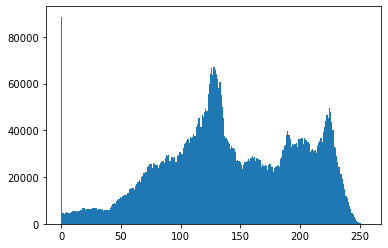

In [ ]:
hist = plt.hist(img.ravel(),bins=256, label=os.path.basename(train_img[0]))


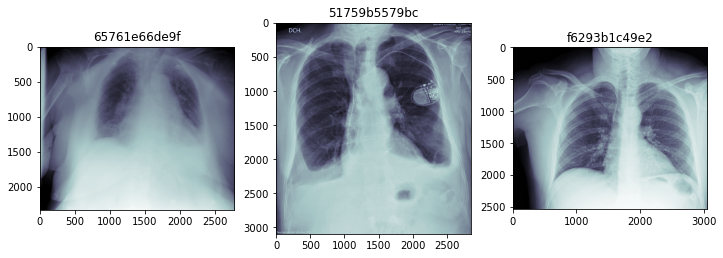

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10, 5))
fig.tight_layout()
for i, path in enumerate(train_img[:3]):
    img = dicom2array(path)
    axs[i].imshow(img, cmap=plt.cm.bone)
    axs[i].set_title(os.path.basename(path).split('.')[0])

fig.savefig(os.path.join(master_img_path, 'first_three_cases') + '.png')

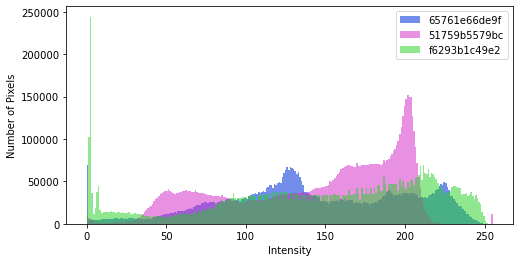

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(dicom2array(train_img[0]).ravel(),bins=256, label=os.path.basename(train_img[0]).split('.')[0], fc=(26/255, 71/255, 220/255, 0.62))
ax.hist(dicom2array(train_img[1]).ravel(),bins=256, label=os.path.basename(train_img[1]).split('.')[0], fc=(211/255, 36/255, 200/255, 0.5))
ax.hist(dicom2array(train_img[2]).ravel(),bins=256, label=os.path.basename(train_img[2]).split('.')[0], fc=(35/255, 209/255, 35/255, 0.5))

ax.set_ylabel('Number of Pixels')
ax.set_xlabel('Intensity')
ax.legend()
plt.show()

fig.savefig(os.path.join(master_img_path, os.path.basename(train_img[0]).split('.')[0]) + '_histogram.png')

In [6]:
from master_lib.image_processing import processing
dcm = processing.load_dicom_image(train_img[0])
bboxes = dataset[os.path.basename(train_img[0])]['boxes']
img = processing.apply_bbox_from_metadata(dcm, bboxes)
img_to_view = cv2.resize(img, (int(img.shape[0]/3), int(img.shape[1]/3)))

In [7]:
print(type(img_to_view))
print(img_to_view.shape)

# plt.hist(img_to_view)

to_save = Image.fromarray(img_to_view)
to_save.save(os.path.join(master_img_path, os.path.basename(train_img[0])) + '_from_functions.png')

<class 'numpy.ndarray'>
(927, 776)


In [ ]:
cv2.imshow("Image", img_to_view)

Error: Session cannot generate requests

In [39]:
a = 1.678

In [40]:
int(a)

1

In [42]:
np.ceil(a)

2.0

In [114]:
# patches: 
img = dicom2array(train_img[1])
print(img.shape)
patch_size = (512, 512)
overleap = 0.9

(3093, 2850)


In [115]:
path_1 = img[:patch_size[0], :patch_size[1]]
temp_x = int(np.floor(patch_size[1]*overleap)) # columns
temp_y = int(np.floor(patch_size[0]*overleap)) # rows
path_2 = img[:patch_size[1], temp_x:temp_x + patch_size[1]]

In [124]:
d = img.shape[0]//patch_size[0]
(d+1)*patch_size[0], img.shape

(3584, (3093, 2850))

In [125]:
"""
[[1, 2, 3, 4],
[2, 3, 4, 5],
[5, 6, 7, 8]]

rows = 4
cols = 3

ZAPAMIETAC TO!
"""
cols_patch = img.shape[1]//patch_size[1]
if cols_patch*patch_size[1] < img.shape[1]:
    cols_patch += 1

rows_patch = img.shape[0]//patch_size[0]
if rows_patch*patch_size[0] < img.shape[0]:
    rows_patch += 1

img_new = np.zeros(shape=(rows_patch*patch_size[0], cols_patch*patch_size[1]))
print(img_new.shape)
img_new[:img.shape[0], :img.shape[1]] = img

(3584, 3072)


In [169]:
def make_patch_from_image(img: np.ndarray, patch_size: tuple) -> list:
    rows_patch = img.shape[0]//patch_size[0]
    cols_patch = img.shape[1]//patch_size[1]

    if rows_patch*patch_size[0] < img.shape[0]:
        rows_patch += 1

    if cols_patch*patch_size[1] < img.shape[1]:
        cols_patch += 1

    img_new = np.zeros(shape=(rows_patch*patch_size[0], cols_patch*patch_size[1]))
    img_new[:img.shape[0], :img.shape[1]] = img

    patches = []
    for row in range(rows_patch):
        for col in range(cols_patch):
            patches.append(img_new[row*patch_size[0]:(row+1)*patch_size[0], col*patch_size[1]:(col+1)*patch_size[1]])

    return patches


In [172]:
patch_img = make_patch_from_image(img, patch_size)
# patch_img

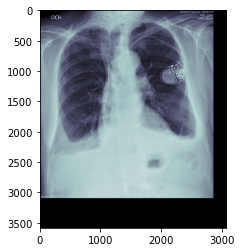

In [134]:
plt.imshow(img_new, cmap=plt.cm.bone)

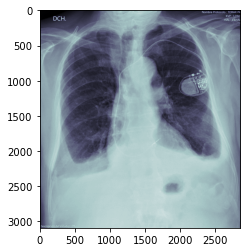

In [168]:
plt.imshow(img, cmap=plt.cm.bone)

In [162]:
patches = []
print(rows_patch, cols_patch)
for row in range(rows_patch):
    for col in range(cols_patch):
        patches.append(img_new[row*patch_size[0]:(row+1)*patch_size[0], col*patch_size[1]:(col+1)*patch_size[1]])

7 6


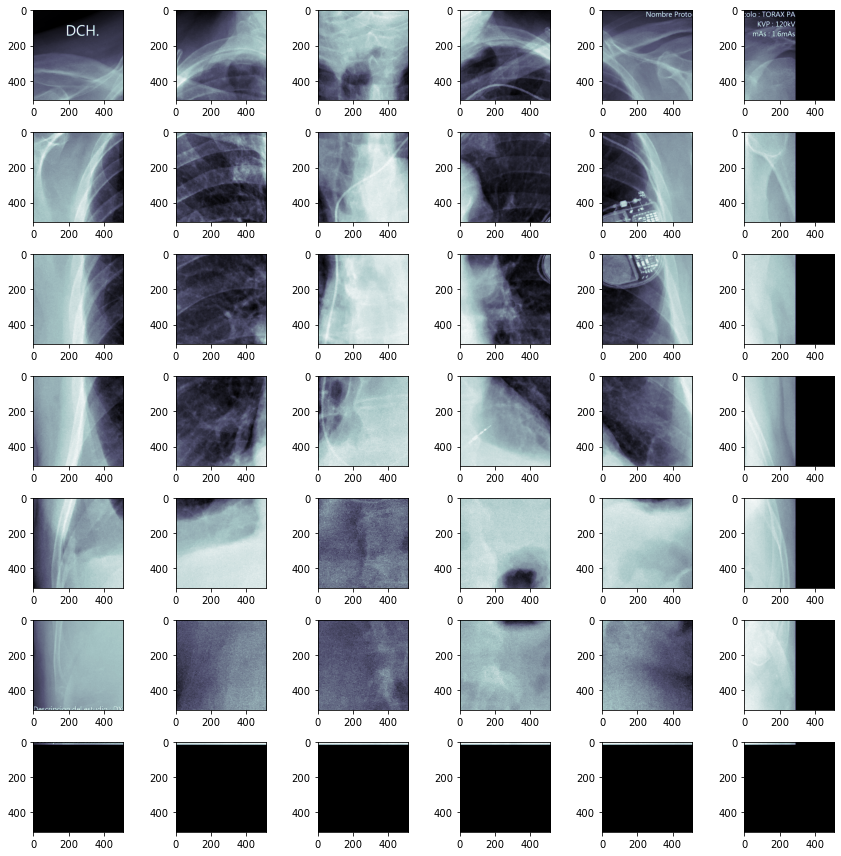

In [166]:
fig, axs = plt.subplots(7, 6, figsize=(12,12))
fig.tight_layout()
j = 0
temp = 0
for i, patch in enumerate(patches):
    if i%6 == 0 and i != 0:
        j += 1
        temp = 0
    axs[j, temp].imshow(patch, cmap=plt.cm.bone)
    temp += 1


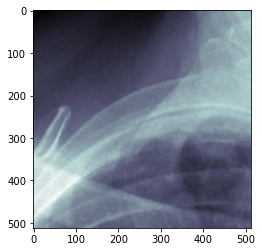

In [72]:

plt.imshow(path_2, cmap=plt.cm.bone)

<function matplotlib.pyplot.show(close=None, block=None)>

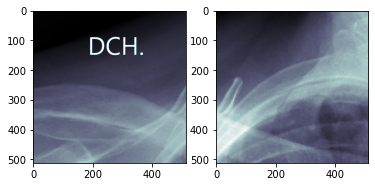

In [73]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(path_1, cmap=plt.cm.bone)
axs[1].imshow(path_2, cmap=plt.cm.bone)

plt.show

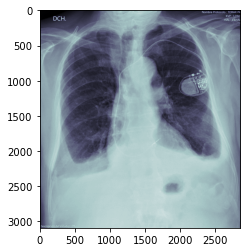

In [66]:
plt.imshow(img, cmap=plt.cm.bone)

In [122]:
t = np.array([[1, 2, 3], [5, 6, 7]])

In [123]:
t.shape

(2, 3)

In [90]:
np.resize(t, (3, 4))

array([[1, 2, 3, 5],
       [6, 7, 1, 2],
       [3, 5, 6, 7]])

In [93]:
t.resize((3,4))

In [94]:
t

array([[1, 2, 3, 5],
       [6, 7, 0, 0],
       [0, 0, 0, 0]])

In [174]:
img.shape

(3093, 2850)

In [175]:
from master_lib.image_processing.preprocessing import convert_image_to_patches

In [179]:
patches = convert_image_to_patches(img, (512, 512), 0.9)

In [180]:
len(patches)

49

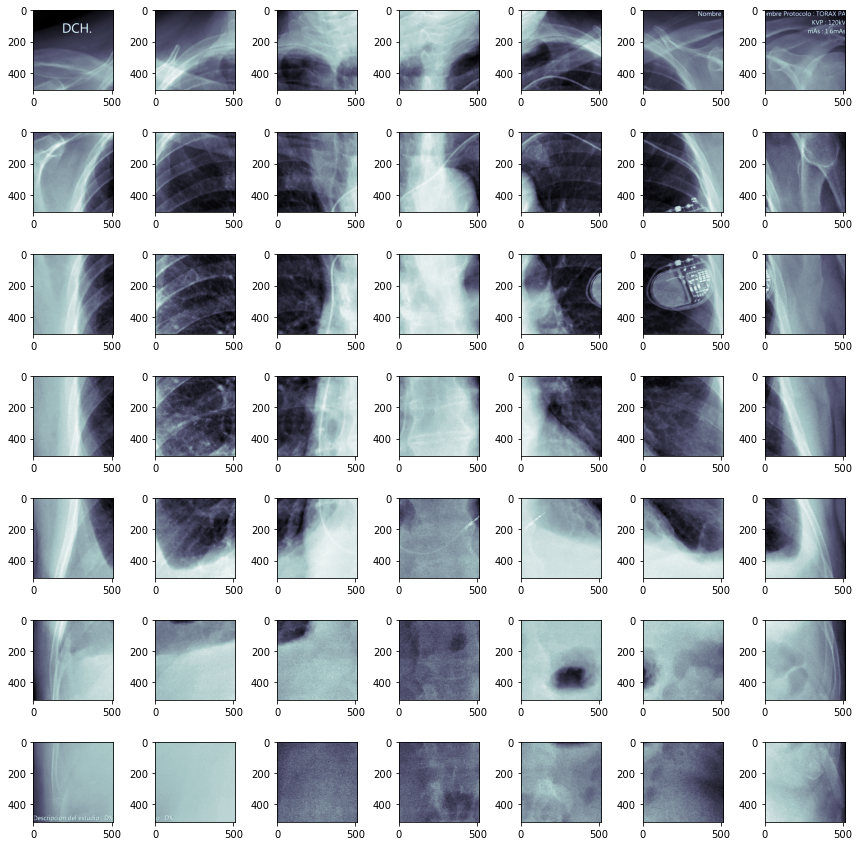

In [182]:
fig, axs = plt.subplots(7, 7, figsize=(12,12))
fig.tight_layout()
j = 0
temp = 0
for i, patch in enumerate(patches):
    if i%7 == 0 and i != 0:
        j += 1
        temp = 0
    axs[j, temp].imshow(patch, cmap=plt.cm.bone)
    temp += 1